## Anomaly Detection using AutoEncoders

#PAD MAJOR PROJECT 


---
#Anomaly Detection on HDFC Stock Market Data 


---


In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go


np.random.seed(1)
tf.random.set_seed(1)



In [ ]:
#loading the hdfc dataset
data = pd.read_csv("/content/drive/MyDrive/Datasets/HDFCBANK.csv")
df = data[:1006]
df.head(-1)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,NaN,NaN,NaN
1,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,NaN,NaN,NaN
2,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,NaN,NaN,NaN
3,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,NaN,NaN,NaN
4,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,2003-12-29,HDFCBANK,EQ,358.60,362.00,385.05,362.00,385.05,379.80,371.38,397287,1.475464e+13,NaN,218780.0,0.5507
1001,2003-12-30,HDFCBANK,EQ,379.80,381.00,383.75,365.00,367.00,368.05,378.34,1049503,3.970712e+13,NaN,886052.0,0.8443
1002,2003-12-31,HDFCBANK,EQ,368.05,370.00,377.50,363.15,366.10,365.10,369.66,221920,8.203481e+12,NaN,120078.0,0.5411
1003,2004-01-01,HDFCBANK,EQ,365.10,363.00,368.00,359.50,367.55,366.65,365.57,188854,6.903869e+12,NaN,77675.0,0.4113


In [ ]:
#selecting features we need
df = df[['Date','Close']]
#converting string dateTime into python dateTime Object
df['Date'] = pd.to_datetime(df['Date'])
#creating range for date
df['Date'].min(),df['Date'].max()

(Timestamp('2000-01-03 00:00:00'), Timestamp('2004-01-05 00:00:00'))

In [ ]:
#Visualising the timeseries
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],y=df['Close'],name="Close Price"))
fig.update_layout(showlegend=True,title="HDFC Stock Price from 2000-2021")
fig.show()

In [ ]:
#pre-processing the data
#First spltting the data into train-test
train, test = df.loc[df['Date'] <= '2003-01-03'], df.loc[df['Date'] > '2003-01-03']
train.shape, test.shape

((752, 2), (254, 2))

In [ ]:
#Standardize the data
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#creating sequence,Convert input data into 3-D array combining TIME_STEPS. 
#The shape of the array should be [samples, TIME_STEPS, features], as required for LSTM network.
#We want our network to have memory of 30 days, so we set TIME_STEPS=30.
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (722, 30, 1)
Testing shape: (224, 30, 1)


In [ ]:
#building the model
#LSTM Autoencoder architecture that expects input sequences with 30 time steps and one feature and outputs a sequence with 30 time steps and one feature.
#RepeatVector() repeats the inputs 30 times.
#Set return_sequences=True, so the output will still be a sequence.
#TimeDistributed(Dense(X_train.shape[2])) is added at the end to get the output, where X_train.shape[2] is the number of features in the input data.
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [ ]:
#training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/100
21/21 [==============================] - 6s 123ms/step - loss: 0.4072 - val_loss: 0.2583
Epoch 2/100
21/21 [==============================] - 2s 74ms/step - loss: 0.3260 - val_loss: 0.4925
Epoch 3/100
21/21 [==============================] - 1s 68ms/step - loss: 0.2888 - val_loss: 0.3208
Epoch 4/100
21/21 [==============================] - 1s 67ms/step - loss: 0.2500 - val_loss: 0.2764


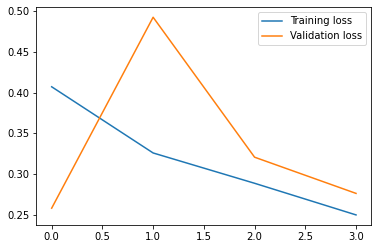

In [ ]:
#plotting the results of training loss & validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
#evaluating the model
model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 23ms/step - loss: 0.7302


0.7301558256149292

Reconstruction error threshold: 1.2


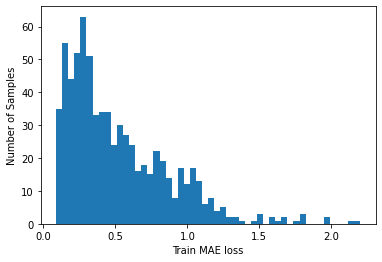

In [ ]:
#Now,determining the anomalies
#Make the max MAE loss value in the training data as the reconstruction error threshold.
#If the reconstruction loss for a data point in the test set is greater than this reconstruction error threshold value then we will label this data point as an anomaly.
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# threshold = np.min(train_mae_loss)
threshold = 1.2
print(f'Reconstruction error threshold: {threshold}')

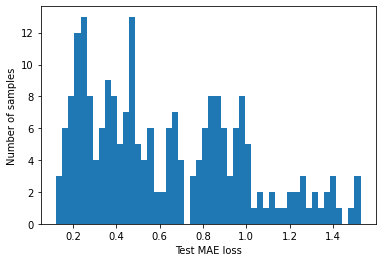

In [ ]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(21, 5)

In [ ]:

#Visualize Anomalies
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()